In [10]:
import scanpy as sc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [232]:
from skimage.filters import threshold_otsu
from sklearn.model_selection import train_test_split
from scipy.spatial import distance
import numpy as np
from glob import glob
from scipy import misc
from matplotlib.patches import Circle,Ellipse
from matplotlib.patches import Rectangle
import os
from PIL import Image

In [141]:
import tensorflow.keras
from matplotlib import pyplot as plt
import numpy as np
import gzip
%matplotlib inline
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Conv2DTranspose
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import RMSprop, Adam
from tensorflow.keras.layers import ZeroPadding2D

In [84]:
adda = sc.read_h5ad('smaller_dada.h5ad')
gene_names = adda.var.index.tolist()
row_col = adda.obs[['array_row', 'array_col']].values.astype(int)
df = pd.DataFrame(data=np.concatenate((row_col, adda.X), axis=1), columns=['row', 'col'] + gene_names)
df['row'] = df['row'].astype(int)
df['col'] = df['col'].astype(int)

RESIZE_WIDTH = 128
RESIZE_HEIGHT = 64

def resize_gene_maps(gene_map):
    img = Image.fromarray(np.uint8(gene_map * 255) , 'L')
    img = img.resize((RESIZE_WIDTH, RESIZE_HEIGHT))
    img = np.asarray(img) / 255
    return img

def min_max_scale(gm):
    not_nan_values = gm[~np.isnan(gm)]
    mx = not_nan_values.max()
    mn = not_nan_values.min()
    gm = gm - mn
    gm = gm / (mx - mn)
    return gm

def make_gene_map(gene_df, gene_name):
    gm = min_max_scale(gene_df.pivot('row', 'col', gene_name).values)
    gm[np.isnan(gm)] = 0
    gm = gm[1:-1]
    gm = np.concatenate((np.zeros([RESIZE_HEIGHT, RESIZE_WIDTH - gm.shape[1]]), gm), axis=1)
    return gm

# row_len = row_col[:, 0].max() - row_col[:, 0].min() + 1
# col_len = row_col[:, 1].max() - row_col[:, 1].min() + 1
gene_maps = np.zeros([len(gene_names), RESIZE_HEIGHT, RESIZE_WIDTH], dtype=np.float32)
for i, name in enumerate(gene_names):
    gene_maps[i] = make_gene_map(df, name)

In [85]:
gene_maps.max()

1.0

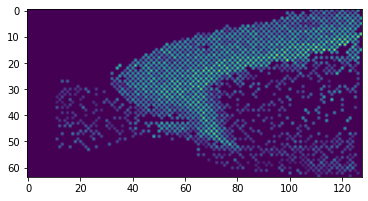

In [80]:
data = gene_maps
data1 = gene_maps[gene_names.index('Vxn')]

plt.imshow(data1)
plt.show()

In [102]:
images = gene_maps
images_arr = np.asarray(images)
images_arr = images_arr.astype('float32')

images_arr = np.expand_dims(images_arr, -1)


In [106]:
images_arr.shape

(1500, 64, 128, 1)

In [107]:
train_X, valid_X, train_ground, valid_ground = train_test_split(images_arr,
                                                             images_arr,
                                                             test_size=0.2,
                                                             random_state=13)

In [108]:
train_X.shape

(1200, 64, 128, 1)

In [196]:
batch_size = 128
epochs = 100

inChannel = 1
x, y = train_X.shape[1], train_X.shape[2]
input_img = Input(shape = (x, y, inChannel))

In [197]:
def autoencoder(cropped):
    #encoder
    h = Conv2D(8, (3, 3), activation='relu', padding='same', strides=(2, 2))(cropped)
    h = Conv2D(16, (3, 3), activation='relu', padding='same', strides=(2, 2))(h)
    h = Conv2D(32, (3, 3), activation='relu', padding='same', strides=(2, 2))(h)

    # decoder
    h = Conv2DTranspose(32, (3, 3), activation='relu', padding='same', strides=(2, 2))(h)
    h = Conv2DTranspose(16, (3, 3), activation='relu', padding='same', strides=(2, 2))(h)
    h = Conv2DTranspose(1, (3, 3), activation='relu', padding='same', strides=(2, 2))(h)
    return h

In [198]:
autoencoder = Model(input_img, autoencoder(input_img))
autoencoder.compile(loss='mean_squared_error', optimizer = Adam(learning_rate=0.0003))

In [199]:
autoencoder.summary()

Model: "model_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         [(None, 64, 128, 1)]      0         
_________________________________________________________________
conv2d_63 (Conv2D)           (None, 32, 64, 8)         80        
_________________________________________________________________
conv2d_64 (Conv2D)           (None, 16, 32, 16)        1168      
_________________________________________________________________
conv2d_65 (Conv2D)           (None, 8, 16, 32)         4640      
_________________________________________________________________
conv2d_transpose_32 (Conv2DT (None, 16, 32, 32)        9248      
_________________________________________________________________
conv2d_transpose_33 (Conv2DT (None, 32, 64, 16)        4624      
_________________________________________________________________
conv2d_transpose_34 (Conv2DT (None, 64, 128, 1)        145

In [200]:
autoencoder_train = autoencoder.fit(train_X, 
                                    train_ground, 
                                    batch_size=batch_size,
                                    epochs=epochs,
                                    verbose=1,
                                    validation_data=(valid_X, valid_ground))

Epoch 1/100
10/10 [==============================] - 1s 61ms/step - loss: 0.0118 - val_loss: 0.0110
Epoch 2/100
10/10 [==============================] - 0s 41ms/step - loss: 0.0113 - val_loss: 0.0104
Epoch 3/100
10/10 [==============================] - 0s 41ms/step - loss: 0.0106 - val_loss: 0.0097
Epoch 4/100
10/10 [==============================] - 0s 42ms/step - loss: 0.0096 - val_loss: 0.0087
Epoch 5/100
10/10 [==============================] - 0s 42ms/step - loss: 0.0085 - val_loss: 0.0075
Epoch 6/100
10/10 [==============================] - 0s 43ms/step - loss: 0.0071 - val_loss: 0.0063
Epoch 7/100
10/10 [==============================] - 0s 41ms/step - loss: 0.0060 - val_loss: 0.0056
Epoch 8/100
10/10 [==============================] - 0s 41ms/step - loss: 0.0054 - val_loss: 0.0052
Epoch 9/100
10/10 [==============================] - 0s 41ms/step - loss: 0.0051 - val_loss: 0.0050
Epoch 10/100
10/10 [==============================] - 0s 44ms/step - loss: 0.0049 - val_loss: 0.0048

Test Images


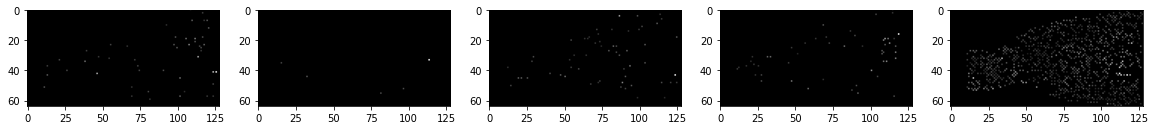

Reconstruction of Test Images


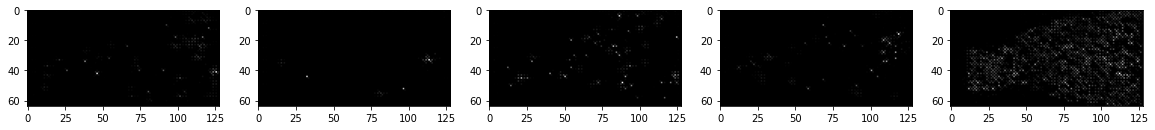

In [201]:
# %%
pred = autoencoder.predict(valid_X)


# %%

plt.figure(figsize=(20, 4))
print("Test Images")
for i in range(5):
    plt.subplot(1, 5, i+1)
    plt.imshow(valid_ground[i, ..., 0], cmap='gray')
plt.show()    
plt.figure(figsize=(20, 4))
print("Reconstruction of Test Images")
for i in range(5):
    plt.subplot(1, 5, i+1)
    plt.imshow(pred[i, ..., 0], cmap='gray')  
plt.show()

In [207]:
intermediate_layer_model = Model(inputs=autoencoder.input,
                                       outputs=autoencoder.get_layer('conv2d_65').output)

In [226]:
x = np.expand_dims(gene_maps[1], [0, -1])
print(x.shape)
feat = intermediate_layer_model.predict(x)

(1, 64, 128, 1)


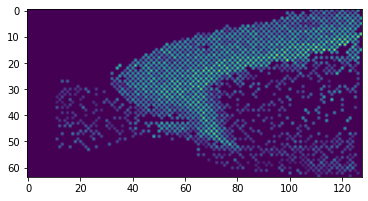

In [229]:
plt.imshow(x[0, :, :, 0])
plt.show()

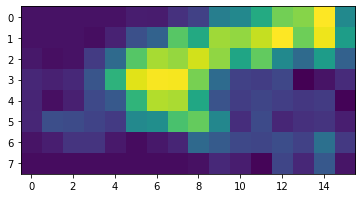

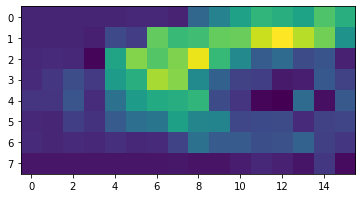

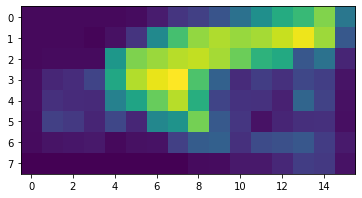

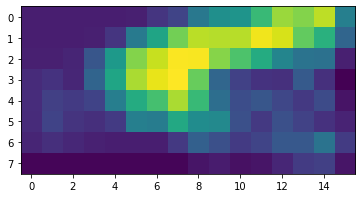

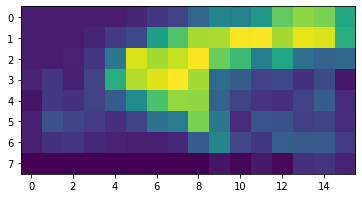

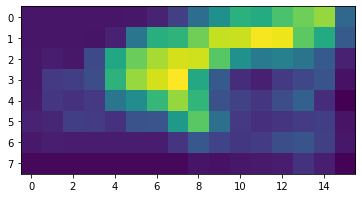

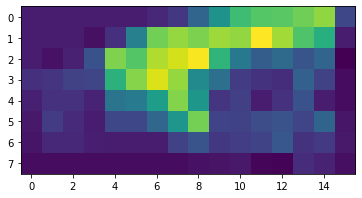

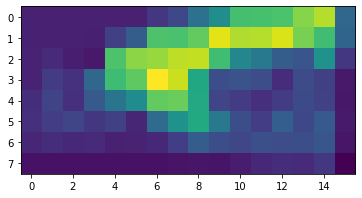

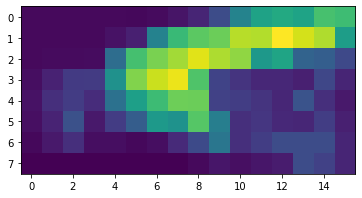

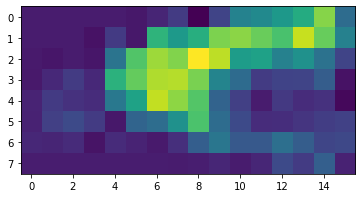

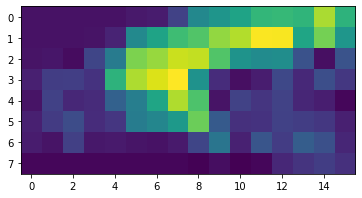

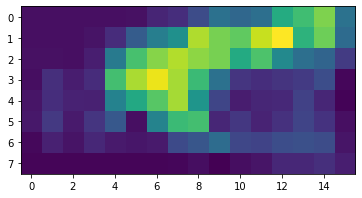

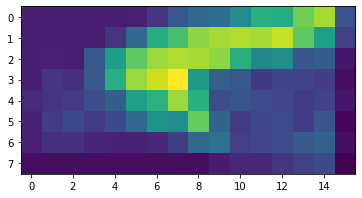

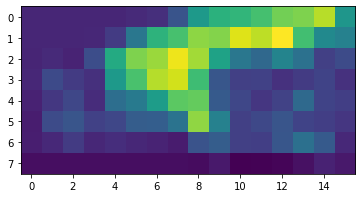

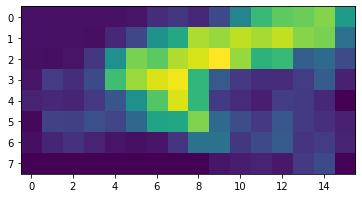

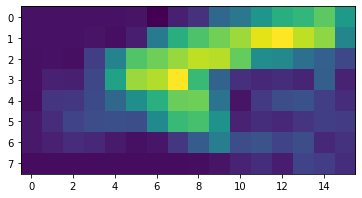

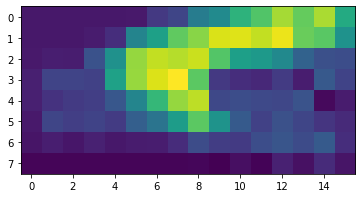

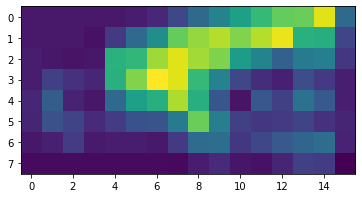

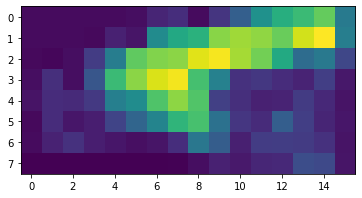

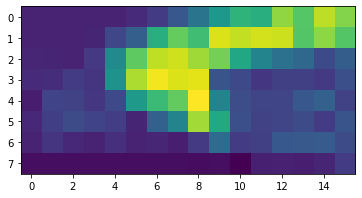

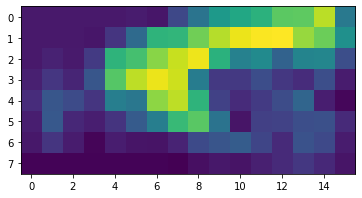

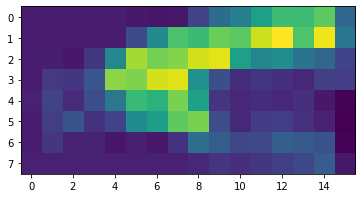

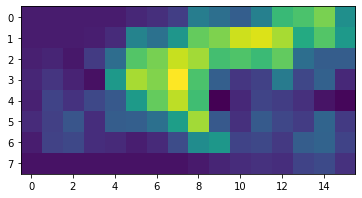

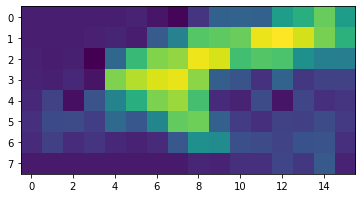

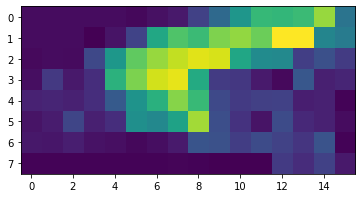

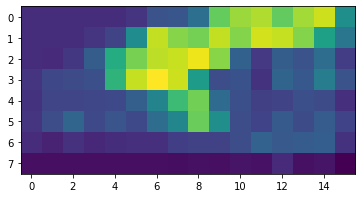

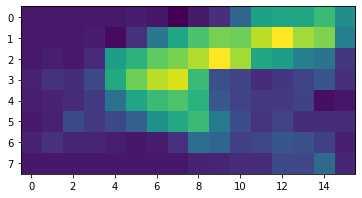

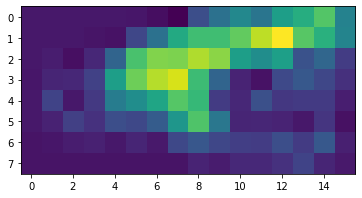

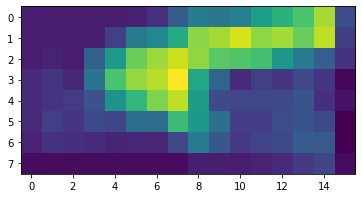

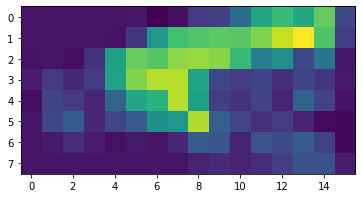

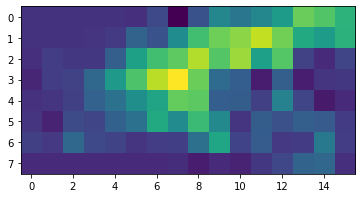

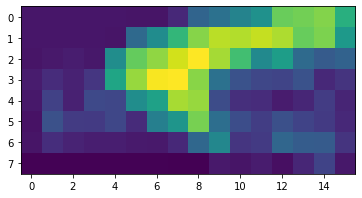

In [228]:
for i in range(32):
    plt.imshow(feat[0, :, :, i])
    plt.show()

In [ ]:
def find_similar_genes(target_feat, all_features, top_k=10):
    dist = [distance.cosine(target_feat, all_features[i]) for i in range(all_features.shape[0])]
    top_k_idx = np.argsort(dist)[1:top_k+1]
    return top_k_idx

def find_similar_genes_euclidean(target_feat, all_features, top_k=10):
    dist = [np.square(target_feat - all_features[i]).sum() for i in range(all_features.shape[0])]
    top_k_idx = np.argsort(dist)[1:top_k+1]
    return top_k_idx

def find_similar_genes_dot_prod(target_feat, all_features, top_k=10):
    dist = [-1 * (target_feat * all_features[i]).sum() for i in range(all_features.shape[0])]
    top_k_idx = np.argsort(dist)[1:top_k+1]
    return top_k_idx

In [230]:
x = np.expand_dims(gene_maps, -1)
all_feats = intermediate_layer_model.predict(x)

In [233]:
all_feats = all_feats.reshape(all_feats.shape[0], -1)

In [237]:
def find_similar_genes_consine(target_feat, all_features, top_k=10):
    dist = [distance.cosine(target_feat, all_features[i]) for i in range(all_features.shape[0])]
    top_k_idx = np.argsort(dist)[1:top_k+1]
    return top_k_idx

def find_similar_genes_euclidean(target_feat, all_features, top_k=10):
    dist = [np.square(target_feat - all_features[i]).sum() for i in range(all_features.shape[0])]
    top_k_idx = np.argsort(dist)[1:top_k+1]
    return top_k_idx

def find_similar_genes_dot_prod(target_feat, all_features, top_k=10):
    dist = [-1 * (target_feat * all_features[i]).sum() for i in range(all_features.shape[0])]
    top_k_idx = np.argsort(dist)[1:top_k+1]
    return top_k_idx

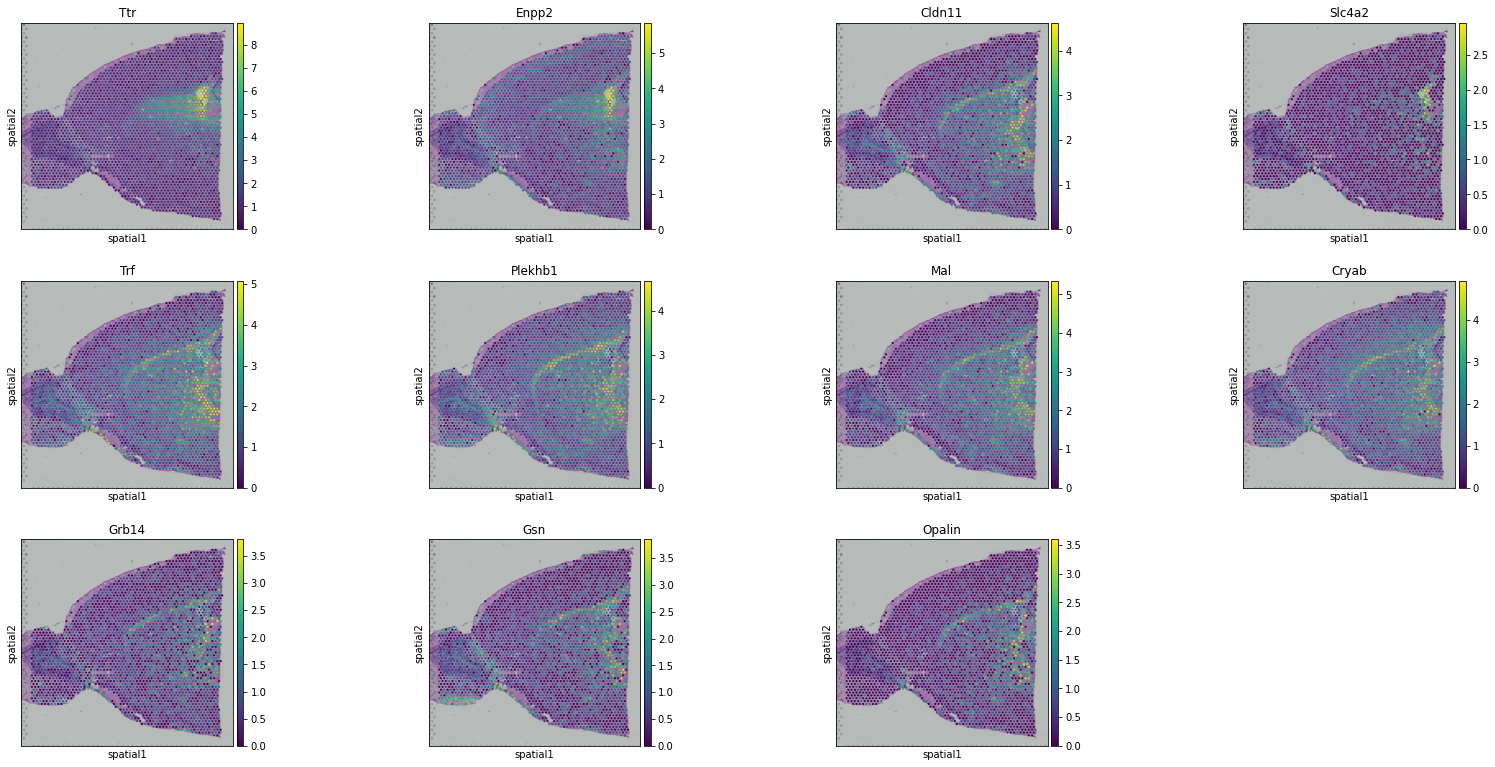

In [244]:
target_gene_name = 'Ttr'
target_gene_idx = gene_names.index(target_gene_name)
top10_genes = find_similar_genes(all_feats[target_gene_idx], all_feats)

sc.pl.spatial(adda, color=[target_gene_name] + [gene_names[i] for i in top10_genes])

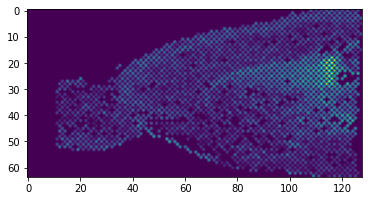

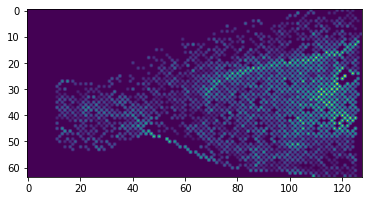

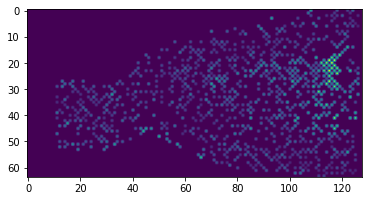

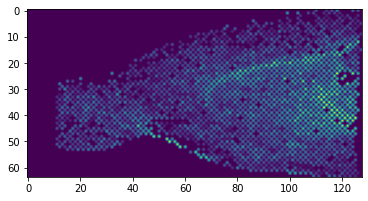

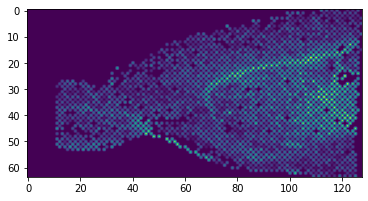

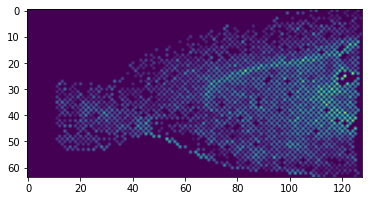

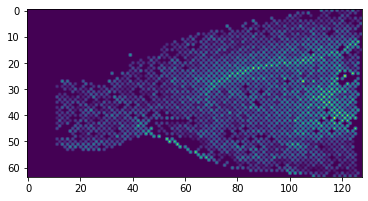

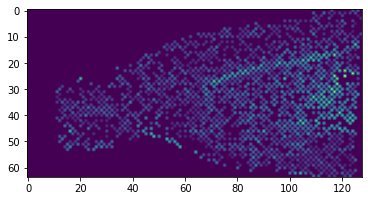

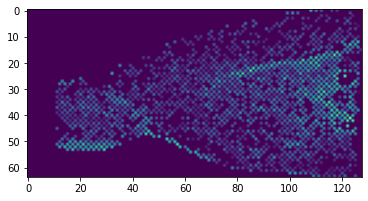

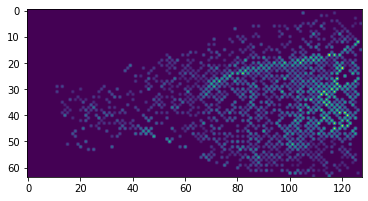

In [243]:
for idx in top10_genes:
    plt.imshow(gene_maps[idx])
    plt.show()

array([ 627,  133,  918,  420, 1028,  628,  438,  985,  598,  778])